# More of the Same 
## Diversity/Homogeneity of Amenities in Neighborhoods as a Measure of Socioeconomic Wellbeing
### Nasruddin Nazerali

### Introduction

Based on spatial data analysis of New York City and Toronto in which I segmented and clustered different neighborhoods based on the available popular amenities on Foursquare, I have made the following observations:
1. The types of amenities in Toronto appear to be more evenly spread around the city compared to New York City.  Most postcodes were clustered to the same label/class based on the categories of the ten most popular Foursquare venues.  This leads me to believe the city may not have a "good side" and "the other side", but offers a uniform experience to residents of any part of town.
2. Some of the clusters in neighborhoods in New York City, especially concentrated in certain burroughs geographically can be characterized by a lack of diversity in types of amenities.  This leads me to hypothesize 'more of the same' types of amenities concentrated in certain neighborhoods.  E.g., fast food, diner, cafe, ... and other variations on restaurants as a majority of the 10 popular/close Foursquare venues.  Thus my title, 'more of the same', or equivalently, 'same difference'.

It is worth asking if the diversity of a city's amenities in different neighborhoods signify the socioeconomic well being of the residents in that area.  We can guess that a neighborhood with a park, public swimming pool, gymnasium, museum, theater, cinema as well as cafes and eateries is a more affluent neighborhood, and the residents have more choice, and socioeconomic well being than residents who can choose only between near synonymous categories of eating/drinking establishments.

Another interesting and complicating factor in U.S cities is racial segregation in residential neighborhoods which persists in some cities as a legacy phenomenon despite legislation which fosters fairness.  Chicago, IL, and Detroit, MI are cases that are cited as some of the more persistently segregated.  Note [this](https://www.washingtonpost.com/graphics/2018/national/segregation-us-cities/?noredirect=on&utm_term=.fab41c11190e) Washington Post article with good geospatial visualization.

As Chicago has extensive data on socioeconomic indicators, school performance, and crime, which we have examined in previous IBM classes, it is an ideal case study to examine if there is a correlation between diversity of amenity types concentrated in certain neighborhoods and socioeconomic well being.

*Urban planners, city officials, developers and community organizers could benefit from a quantitative study of this type.*

### Data

This data analysis would benefit from some breadth as well as depth.  In the course of the IBM Capstone class, I have performed the segmentation/clustering analysis of New York City (all burroughs) and Toronto using the Foursquare data.  The following tasks would round out that analysis and add more insight in terms of breadth:
1. Reexamine the clustering parameters and analyze the performance of different models.
2. Quantify the diversity of categories of venues.  This can be a heuristic parameter that makes a kind of entropy index from the clustering output, or the clustering can be re-parametrized as part of task 1.
3. Peform the same analysis on a representative sample of U.S. cities including Chicago. (San Fransisco - as we have crimes data as well - and Atlanta for a good geographic spread.)

For the case of Chicago an in depth analysis is possible due to extensive and well-curated data and can yield an answer to the hypothesis that socio economic factors will track in correlation to diversity of amenities.  Data sets include
1. [Chicago Public Schools - Progress Report Cards (2011-2012)](https://data.cityofchicago.org/Education/Chicago-Public-Schools-Progress-Report-Cards-2011-/9xs2-f89t)
2. [Crimes - One Year Prior to Present](https://data.cityofchicago.org/Public-Safety/Crimes-One-year-prior-to-present/x2n5-8w5q)
3. [Census Data - Selected Socioeconomic Indicators 2008-2012](https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2)

The parametrization can be kept to a basic level to start in order to combine data sets, e.g., aggregate report card score, frequency of crimes and hardship index for all neighborhoods.  This can be refined incrementally.  Some work is needed to aggregate 'community areas', crime geolocations and school zipcodes into neighborhoods to query on Foursquare.

### 1. Revisiting New York City

In [1]:
#anticipating most of the libraries we will need as per previous labs on Cognitive Class
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.19.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  24.19 MB/s
geopy-1.19.0-p 100% |################################| Time: 0:00:00  37.11 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  49.16 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  30.35 MB/s
vincent-0.4.4- 100% |###################

Next few steps reproduce previous analysis for all boroughs of NYC similar to analysis performed on Manhattan only.

1. Download data from IBM servers -- the original data can be found from the NYU Spatial Data Repository [here](https://geo.nyu.edu/catalog/nyu_2451_34572)

2. Pick the 'features' from the json data and prepare as a pandas dataframe

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
NYCneighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in NYCneighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


We follow up with the remaining steps to visualize the data and cluster neighborhoods according to category of the nearby venues queried from the Foursquare API.  We can obtain (up to) the top 100 venues in a radius of 500 m.  Determined walkers will tolerate greater distances, so we will explore a radius of 1000 m as well.

In [7]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


In [138]:
#foursquare creds removed

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
#function that extracts the nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [22]:
print(nyc_venues.shape)
print(neighborhoods.shape)
nyc_venues.head()

(10295, 7)
(306, 4)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,SUBWAY,40.890656,-73.849192,Sandwich Place


Our dataframe has over ten thousand venues in 306 neighborhoods in the 5 bouroughs of NYC.

We can immediately see from the venues data frame that eateries of various sorts can be a dominant category.

As we would expect, some more densely settled or busy work neighborhoods have 100 (max) venues returned, whereas some neighborhoods are in the single digits or just one venue.  See the table below.

In [14]:
nyc_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,27,27,27,27,27,27
Annadale,12,12,12,12,12,12
Arden Heights,5,5,5,5,5,5
Arlington,6,6,6,6,6,6
Arrochar,19,19,19,19,19,19
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,11,11,11,11,11,11
Auburndale,18,18,18,18,18,18


### Venue Categories

Let's see how many unique categories are returned and examine just how unique they really are.

In [15]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 429 uniques categories.


In [16]:
!conda install -c conda-forge wordcloud

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py35_0 conda-forge

wordcloud-1.4. 100% |################################| Time: 0:00:00  41.55 MB/s


In [17]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [18]:
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

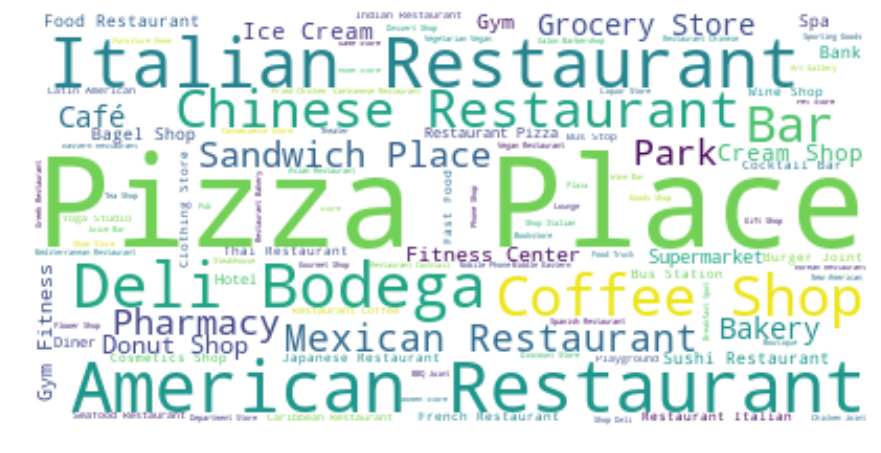

In [20]:
text = nyc_venues['Venue Category'].tolist()
texts = ",".join(text)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=75, max_words=100, background_color="white").generate(texts)

plt.figure(figsize=[15,12])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

It is clear from this simple word cloud that the majority of venues have something to do with food/drink.  Parks, supermarkets, pharmacies, spas, gyms peak out with much smaller frequencies.  Bodegas (small groceries) at least feature more promninently.

We can proceed to perform the clustering of neighborhoods by duplicating the data analysis steps from an earlier lab.  We will encode categorical parameters with one-hot encoding that will indicate yes(1) or no(0) whether the type of venue is present within the designated radius in the neighborhood.  We can then create a numerical parameter by taking the mean of the frequency of occurenc of each category of venue.

We will want to explore a different parameterization as indicated by the preponderance of eating establishments well as other synonymous types (supermarket - grocery, gym - fitness) which can be combined.

In [36]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian R

In [37]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()

In [38]:
# we may want to inspect the most common venues using the following method and creating a new dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
############
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Spa,Supermarket,Pizza Place,Deli / Bodega,Discount Store,Grocery Store,Martial Arts Dojo,Mexican Restaurant,Fast Food Restaurant,Pharmacy
1,Annadale,American Restaurant,Pizza Place,Cosmetics Shop,Dance Studio,Train Station,Sports Bar,Diner,Restaurant,Food,Farmers Market
2,Arden Heights,Pharmacy,Coffee Shop,Pizza Place,Pool,Playground,Women's Store,Farmers Market,Ethiopian Restaurant,Event Service,Event Space
3,Arlington,Intersection,Deli / Bodega,Grocery Store,American Restaurant,Boat or Ferry,Bus Stop,Film Studio,Exhibit,Eye Doctor,Factory
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Athletics & Sports,Taco Place,Middle Eastern Restaurant,Bagel Shop,Outdoors & Recreation,Liquor Store


We will combine the dataframe containing the 10 most common venues by neighborhood shown above with the label outcomes of the clustering step.

In [39]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1.0,Laundromat,Pharmacy,Food Truck,Caribbean Restaurant,Ice Cream Shop,Dessert Shop,Donut Shop,Sandwich Place,Women's Store,Event Service
1,Bronx,Co-op City,40.874294,-73.829939,1.0,Bus Station,Basketball Court,Restaurant,Pizza Place,Grocery Store,Trail,Discount Store,Fast Food Restaurant,Gift Shop,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,1.0,Caribbean Restaurant,Bus Station,Diner,Pizza Place,Bowling Alley,Metro Station,Seafood Restaurant,Automotive Shop,Fast Food Restaurant,Donut Shop
3,Bronx,Fieldston,40.895437,-73.905643,1.0,River,Playground,Plaza,Women's Store,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Bronx,Riverdale,40.890834,-73.912585,0.0,Park,Food Truck,Gym,Plaza,Home Service,Bank,Women's Store,Farm,Ethiopian Restaurant,Event Service


In [41]:
nyc_merged["Cluster Labels"][nyc_merged["Cluster Labels"].isna()]

207   NaN
Name: Cluster Labels, dtype: float64

In [42]:
# problematic row labeled to non-numeric output
nyc_merged.iloc[207]

Borough                   Staten Island
Neighborhood                 Port Ivory
Latitude                        40.6397
Longitude                      -74.1746
Cluster Labels                      NaN
1st Most Common Venue               NaN
2nd Most Common Venue               NaN
3rd Most Common Venue               NaN
4th Most Common Venue               NaN
5th Most Common Venue               NaN
6th Most Common Venue               NaN
7th Most Common Venue               NaN
8th Most Common Venue               NaN
9th Most Common Venue               NaN
10th Most Common Venue              NaN
Name: 207, dtype: object

In [43]:
(nyc_venues['Neighborhood']=='Port Ivory').sum()

0

Port Ivory in Staten Island did not return any venues in the 500 m radius.  We can discard this row for the subsequent analysis.
(NB - in an earlier run, Howland Hook was the neighborhood that returned zero venues.  The Foursquare request does not return identical outputs each time.)

In [44]:
nyc_merged.drop([207],inplace=True)

In [46]:
nyc_merged["Cluster Labels"]=nyc_merged["Cluster Labels"].astype(int) #because we are using the cluster label as an index in the map below

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

At a glance, it appears that cluster labels 2 and 0 (blue and red) are concentrated in boroughs other than Manhattan.  Cluster label 1 (violet) is dominant over all, and we could formulate a tentative hypothesis that it is most likely characterized by the more diverse distribution of amenities (shopping, restaurants, musuems, parks), whereas the other labels will have a more homogeneous distribution (mostly eateries).  

Cluster label 3 and label 4 (cyan and orange) are rare -- each have only one neighborhood.  


(In an earlier run, the anomalous cases were lables 3 and 1 explored below in cells 35 and 36.  Upon a closer look, the geographical location on the eastern and southern edge of the city flanked by marhses or the open sea can explain the unique distribution of venue types in these two neighborhoods.)
#### NB cells 35 to 39 refer to an earlier clustering run.

Let's start by looking at cluster label 3.

In [35]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
179,Neponsit,Beach,Women's Store,Fish & Chips Shop,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market


It appears to be a very diverse neighborhood in terms of amenities close by - including a farm (which must be an urban micro-farm, looking at the map) and a factory.

And cluster label 1.

In [36]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
193,Brookville,Deli / Bodega,Women's Store,Fish & Chips Shop,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm


From a listing of the ten most common venues in Neponsit and Brookville, both in Queens borough, thay appear to be quite similar.  
Let's proceed with a quick examination of the other cluster labels.

In [37]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Sandwich Place,Dessert Shop,Pharmacy,Food Truck,Donut Shop,Laundromat,Caribbean Restaurant,Ice Cream Shop,Farm,Falafel Restaurant
1,Co-op City,Fast Food Restaurant,Pharmacy,Discount Store,Baseball Field,Mattress Store,Grocery Store,Park,Liquor Store,Pizza Place,Gift Shop
3,Fieldston,River,Playground,Plaza,Women's Store,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
4,Riverdale,Park,Food Truck,Bus Station,Gym,Home Service,Plaza,Bank,Women's Store,Farmers Market,Event Space
5,Kingsbridge,Pizza Place,Sandwich Place,Bar,Mexican Restaurant,Supermarket,Discount Store,Pharmacy,Bakery,Donut Shop,Fried Chicken Joint
6,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Diner,Gym,Big Box Store,Shoe Store,Bank,Seafood Restaurant,Clothing Store
9,Williamsbridge,Nightclub,Bar,Caribbean Restaurant,Soup Place,Playground,Event Service,Event Space,Exhibit,Eye Doctor,Factory
10,Baychester,Fried Chicken Joint,Discount Store,Mexican Restaurant,Mattress Store,Pet Store,Bank,Electronics Store,Fast Food Restaurant,Sandwich Place,Pizza Place
12,City Island,Harbor / Marina,Thrift / Vintage Store,Seafood Restaurant,Diner,Park,Bar,Bank,Pharmacy,Sandwich Place,Smoke Shop
15,Morris Heights,Food Truck,Spanish Restaurant,Grocery Store,Recreation Center,Playground,Pizza Place,IT Services,Park,Check Cashing Service,Bus Station


In [77]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Eastchester,Caribbean Restaurant,Deli / Bodega,Bus Station,Bus Stop,Diner,Donut Shop,Metro Station,Bakery,Fast Food Restaurant,Seafood Restaurant
7,Woodlawn,Deli / Bodega,Playground,Pizza Place,Convenience Store,Bar,Pharmacy,Donut Shop,Train Station,Moving Target,Supermarket
8,Norwood,Deli / Bodega,Pizza Place,Park,Bank,Mobile Phone Shop,Chinese Restaurant,Pharmacy,Sandwich Place,Supermarket,Bus Station
11,Pelham Parkway,Deli / Bodega,Italian Restaurant,Chinese Restaurant,Pizza Place,Thai Restaurant,Sushi Restaurant,Track,Eye Doctor,Sandwich Place,Smoke Shop
13,Bedford Park,Pizza Place,Deli / Bodega,Diner,Sandwich Place,Fried Chicken Joint,Chinese Restaurant,Mexican Restaurant,Supermarket,Train Station,Dry Cleaner
14,University Heights,Chinese Restaurant,Fried Chicken Joint,Pizza Place,Bank,Sandwich Place,History Museum,Donut Shop,Fast Food Restaurant,Bakery,Laundromat
17,East Tremont,Pizza Place,Café,Shoe Store,Spanish Restaurant,Bank,Mexican Restaurant,Lounge,Paella Restaurant,Mobile Phone Shop,Fast Food Restaurant
19,High Bridge,Pharmacy,Pizza Place,Chinese Restaurant,Park,Seafood Restaurant,Sandwich Place,Bus Station,Discount Store,Check Cashing Service,Market
20,Melrose,Pizza Place,Pharmacy,Supermarket,Discount Store,Gym / Fitness Center,Paper / Office Supplies Store,Spanish Restaurant,Clothing Store,Gym,Donut Shop
21,Mott Haven,Gym,Pizza Place,Spanish Restaurant,Peruvian Restaurant,Donut Shop,Baseball Field,Burger Joint,Grocery Store,Bakery,Pharmacy


In [38]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Clason Point,Park,Scenic Lookout,Grocery Store,Bus Stop,Boat or Ferry,South American Restaurant,Pool,Women's Store,Event Space,Exhibit
192,Somerville,Park,Women's Store,English Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
198,New Brighton,Bus Stop,Park,Deli / Bodega,Playground,Convenience Store,Bowling Alley,Discount Store,Farmers Market,Field,Fast Food Restaurant
203,Todt Hill,Trail,Park,Women's Store,Field,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
245,Bloomfield,Recreation Center,Theme Park,Park,Bus Stop,Discount Store,Women's Store,Field,Event Space,Exhibit,Eye Doctor
256,Randall Manor,Park,Bus Stop,Bagel Shop,Deli / Bodega,Pizza Place,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory


As a first order observation of the tables of the clustered neighborhoods we can see that:
- cluster 2 (everywhere other than Manhattan) has ethnically diverse establishments, mostly restaurants;
- cluster 4 (mostly Staten Island and Clason Point, The Bronx and Somerville, Queens - both on the shoreline) has venues associated with the geogrphaphical location; parks, trails, and event spaces;
- cluster 0 (Manhattan and other boroughs) has a diversity of venues, with no outstanding or unique feature.  In a sese, this is the most generic type of neighborhood.

Just to check that all Manhattan neighborhoods were labeled as cluster 0.

In [39]:
sum(nyc_merged[nyc_merged['Borough']=='Manhattan']['Cluster Labels'] != 0)

0

### Discussion
The results above appear to reasonably differentiate neighborhoods by the types of common venues available.  We proceed to investigate alternative models that could possibly provide a higher level of insight that is masked by finer details.

1. Cluster with a fewer number of clusters (would two clusters show 'good' and 'bad' neighborhoods in terms of availability of amenities?)
2. Cluster by the category of venues higher in the hierarchy of categorization ('food' for all sorts of eateries, 'arts and entertainment' for a variety of venues such as museums and golf clubs, etc.) . The [Foursquare venue category hierarchy](https://developer.foursquare.com/docs/resources/categories) can be referred to. 

In [11]:
# set number of clusters
kclusters = 2

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

NameError: name 'nyc_grouped' is not defined

In [70]:
# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2.head()

# add clustering labels
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0.0,Laundromat,Pharmacy,Food Truck,Caribbean Restaurant,Ice Cream Shop,Dessert Shop,Donut Shop,Sandwich Place,Women's Store,Event Service
1,Bronx,Co-op City,40.874294,-73.829939,0.0,Bus Station,Basketball Court,Restaurant,Pizza Place,Grocery Store,Trail,Discount Store,Fast Food Restaurant,Gift Shop,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,0.0,Caribbean Restaurant,Bus Station,Diner,Pizza Place,Bowling Alley,Metro Station,Seafood Restaurant,Automotive Shop,Fast Food Restaurant,Donut Shop
3,Bronx,Fieldston,40.895437,-73.905643,0.0,River,Playground,Plaza,Women's Store,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Bronx,Riverdale,40.890834,-73.912585,1.0,Park,Food Truck,Gym,Plaza,Home Service,Bank,Women's Store,Farm,Ethiopian Restaurant,Event Service


In [71]:
nyc_merged["Cluster Labels"][nyc_merged["Cluster Labels"].isna()]

207   NaN
Name: Cluster Labels, dtype: float64

In [72]:
nyc_merged.drop([207],inplace=True)
nyc_merged["Cluster Labels"]=nyc_merged["Cluster Labels"].astype(int) #because we are using the cluster label as an index in the map below

In [73]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Clustering with just two labels shows that New York City has a more or less uniform distribution of venue types.  The few neighborhoods with cluster label 1 (blue) are geographically similar.  They are mostly near the riverfront or on the shoreline.

In [ ]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

It appears that these sites have parks, event spaces and other varieties of non-food venues.

#### We can proceed to parse out the higher category of each venue.

At this stage I experimented with the Foursquare venue category hierarchy.  It would be a nice extra to visualize the hierarchy as a tree but I prioritized building a new definition of the *getVenue* function to pick uo the highest category of each venue, i.e., food, shop, etc. and proceed to do a clustering with these new parameters.

In [58]:
urlH = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)

NameError: name 'CLIENT_ID' is not defined

In [86]:
resultsHierarchy = requests.get(urlH).json()

In [87]:
#resultsHierarchy

In [54]:
import json
with open('data.json', 'w') as outfile: json.dump(resultsHierarchy, outfile)
    

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [80]:
#function that extracts the nearby venues (second version)
def getNearbyVenue(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            urlparse.urlparse(v['venue']['categories'][0]['icon']['prefix']).path.split('/')[-2]) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [76]:
nyc_venue1

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,food
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,shops
2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,food
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,food
4,Wakefield,40.894705,-73.847201,Dunkin Donuts,40.890459,-73.849089,food
5,Wakefield,40.894705,-73.847201,SUBWAY,40.890656,-73.849192,food
6,Wakefield,40.894705,-73.847201,Baychester Avenue Food Truck,40.892293,-73.843230,food
7,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891147,-73.850230,shops


In the above, I checked that this works for one neighborhood before iterating over all of them.

In [83]:
NYC_venues = getNearbyVenue(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [84]:
NYC_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,food
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,shops
2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,food
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,food
4,Wakefield,40.894705,-73.847201,Dunkin Donuts,40.890459,-73.849089,food


In [86]:
print('There are {} uniques categories.'.format(len(NYC_venues['Venue Category'].unique())))

There are 9 uniques categories.


We expect the analysis to follow to be quite different from the preceding where we worked with 429 unique categories.

In [87]:
NYC_venues['Venue Category'].unique()

array(['food', 'shops', 'parks_outdoors', 'travel', 'arts_entertainment',
       'nightlife', 'education', 'building', 'event'], dtype=object)

In [88]:
# one hot encoding
nyc_onehot = pd.get_dummies(NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = NYC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Neighborhood,arts_entertainment,building,education,event,food,nightlife,parks_outdoors,shops,travel
0,Wakefield,0,0,0,0,1,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,1,0
2,Wakefield,0,0,0,0,1,0,0,0,0
3,Wakefield,0,0,0,0,1,0,0,0,0
4,Wakefield,0,0,0,0,1,0,0,0,0


In [89]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()


In [94]:
#nyc_grouped

In [95]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 2, 0, 1, 3, 2, 3, 2, 0, 3], dtype=int32)

In [96]:
num_top_venues = 9

indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Allerton,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
1,Annadale,food,travel,shops,parks_outdoors,nightlife,arts_entertainment,event,education,building
2,Arden Heights,shops,food,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
3,Arlington,travel,food,shops,parks_outdoors,nightlife,event,education,building,arts_entertainment
4,Arrochar,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment


In this case, we are looking at a ranking of all the venue types rather than the top (10) most common as before.

In [97]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,3,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
1,Bronx,Co-op City,40.874294,-73.829939,0,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
2,Bronx,Eastchester,40.887556,-73.827806,3,food,travel,shops,arts_entertainment,parks_outdoors,nightlife,event,education,building
3,Bronx,Fieldston,40.895437,-73.905643,4,parks_outdoors,shops,travel,nightlife,food,event,education,building,arts_entertainment
4,Bronx,Riverdale,40.890834,-73.912585,4,parks_outdoors,shops,food,travel,nightlife,event,education,building,arts_entertainment


In [98]:
nyc_merged["Cluster Labels"][nyc_merged["Cluster Labels"].isna()]

Series([], Name: Cluster Labels, dtype: int32)

No data row with zero venues returned, and not identified in any cluster, as happened before.

In [99]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

At a glance, the clustering output with only the top level categories of the venues looks more interesting than the previous analysis.

In [100]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
1,Co-op City,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
5,Kingsbridge,food,shops,nightlife,parks_outdoors,travel,education,event,building,arts_entertainment
6,Marble Hill,food,shops,education,building,arts_entertainment,travel,parks_outdoors,nightlife,event
8,Norwood,food,shops,parks_outdoors,travel,nightlife,event,education,building,arts_entertainment
10,Baychester,shops,food,building,arts_entertainment,travel,parks_outdoors,nightlife,event,education
14,University Heights,food,shops,travel,arts_entertainment,parks_outdoors,nightlife,event,education,building
15,Morris Heights,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
16,Fordham,food,shops,building,education,parks_outdoors,arts_entertainment,travel,nightlife,event
17,East Tremont,food,shops,nightlife,travel,parks_outdoors,event,education,building,arts_entertainment
19,High Bridge,food,shops,travel,parks_outdoors,building,nightlife,event,education,arts_entertainment


Cluster 0.  Red marker.  Geographically not concentrated in one area.  Ranking of venues -- (by quick inspection) food, shops, nightlife, parks

In [101]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Wakefield,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
2,Eastchester,food,travel,shops,arts_entertainment,parks_outdoors,nightlife,event,education,building
11,Pelham Parkway,food,travel,shops,building,arts_entertainment,parks_outdoors,nightlife,event,education
13,Bedford Park,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
21,Mott Haven,food,shops,travel,building,parks_outdoors,nightlife,event,education,arts_entertainment
22,Port Morris,food,shops,arts_entertainment,travel,parks_outdoors,nightlife,event,education,building
23,Longwood,food,shops,building,travel,parks_outdoors,nightlife,event,education,arts_entertainment
28,Throgs Neck,food,nightlife,travel,shops,parks_outdoors,event,education,building,arts_entertainment
32,Van Nest,food,travel,shops,nightlife,parks_outdoors,event,education,building,arts_entertainment
33,Morris Park,food,shops,nightlife,travel,parks_outdoors,event,education,building,arts_entertainment


Cluster 3.  Cyan marker. As widespread and numerous as label 0, somewhat concentrated in Manhattan.  Top venues include 'building' (e.g. gyms) and 'travel' (e.g. hotels) in addition to food and shops.

In [102]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
3,Fieldston,parks_outdoors,shops,travel,nightlife,food,event,education,building,arts_entertainment
4,Riverdale,parks_outdoors,shops,food,travel,nightlife,event,education,building,arts_entertainment
27,Clason Point,parks_outdoors,travel,shops,food,nightlife,event,education,building,arts_entertainment
76,Mill Island,parks_outdoors,food,travel,shops,nightlife,event,education,building,arts_entertainment
91,Bergen Beach,parks_outdoors,shops,food,travel,nightlife,event,education,building,arts_entertainment
172,Breezy Point,parks_outdoors,travel,building,shops,nightlife,food,event,education,arts_entertainment
179,Neponsit,parks_outdoors,travel,shops,nightlife,food,event,education,building,arts_entertainment
192,Somerville,parks_outdoors,travel,shops,nightlife,food,event,education,building,arts_entertainment
202,Grymes Hill,parks_outdoors,travel,shops,nightlife,food,event,education,building,arts_entertainment
203,Todt Hill,parks_outdoors,travel,shops,nightlife,food,event,education,building,arts_entertainment


Cluster 4.  Orange marker. This cluster ppears clearly correlated with coastal/riverside/island locations geographically.  It makes sense that travel and nightlife venues appear among the top ranking.

In [103]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
18,West Farms,travel,food,parks_outdoors,shops,nightlife,event,education,building,arts_entertainment
85,Sea Gate,shops,travel,parks_outdoors,building,nightlife,food,event,education,arts_entertainment
158,Fresh Meadows,food,travel,shops,parks_outdoors,nightlife,event,education,building,arts_entertainment
164,South Jamaica,travel,food,shops,parks_outdoors,nightlife,event,education,building,arts_entertainment
183,Jamaica Estates,travel,parks_outdoors,nightlife,food,shops,event,education,building,arts_entertainment
198,New Brighton,travel,parks_outdoors,shops,food,arts_entertainment,nightlife,event,education,building
204,South Beach,travel,shops,parks_outdoors,food,nightlife,event,education,building,arts_entertainment
212,Oakwood,travel,shops,parks_outdoors,nightlife,food,event,education,building,arts_entertainment
224,Park Hill,travel,shops,food,building,parks_outdoors,nightlife,event,education,arts_entertainment
226,Graniteville,travel,shops,parks_outdoors,nightlife,food,event,education,building,arts_entertainment


Cluster 1.  Violet marker.  This cluster appears mostly in Queens and Staten Island.  It is prominently absent from Manhattan.  Travel, parks and event spaces appear to rank high.  It could be these venues are not prominent in the densely constructed and settled parts of the city.

In [104]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
7,Woodlawn,food,shops,parks_outdoors,travel,nightlife,event,education,building,arts_entertainment
9,Williamsbridge,food,nightlife,travel,shops,parks_outdoors,event,education,building,arts_entertainment
12,City Island,food,shops,parks_outdoors,arts_entertainment,travel,nightlife,event,education,building
35,Spuyten Duyvil,shops,food,travel,parks_outdoors,arts_entertainment,nightlife,event,education,building
60,Brownsville,food,parks_outdoors,travel,shops,arts_entertainment,nightlife,event,education,building
67,Red Hook,food,shops,arts_entertainment,parks_outdoors,nightlife,travel,event,education,building
78,Coney Island,shops,food,arts_entertainment,parks_outdoors,building,travel,nightlife,event,education
81,Dyker Heights,food,parks_outdoors,shops,arts_entertainment,travel,nightlife,event,education,building
82,Gerritsen Beach,food,shops,parks_outdoors,nightlife,travel,building,event,education,arts_entertainment
83,Marine Park,food,parks_outdoors,shops,building,arts_entertainment,travel,nightlife,event,education


Cluster label 2.  Blue markers.  These appear to be concebtrated around coasts/riverfront neighborhoods.  Parks stand out as a prominent venue.

Clustering based on the top level category of venues appears to be a promising direction for analysis.  It is difficult to make general conclusions re. NYC based on this clustering.  Anecdotal evidence of long-time residents of NYC appear to confirm the general availability of the basic amenities: food (including late night take outs), groceries/pharmacies, and transportation.  It is also true that neighborhoods have ethnic majorities and similar businesses which tend to cluster in certain neighborhoods, and that the boundaries of these neighborhoods are fluid.  Our analysis confirms some common sense observations about geographical features that tend to concentrate certain neighborhoods by the type of most common venue.

For the sake of completeness, let us repeat the clustering with only two clusters.

In [106]:
# set number of clusters
kclusters = 2

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!



nyc_merged["Cluster Labels"][nyc_merged["Cluster Labels"].isna()]



# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In this case, it appears that cluster label 1 (violet marker) is certainly correlated with the geographic feature of being close to the shore or the river front (except a few neighborhoods in the center of Queens.  Let us quickly examine the two clusters.

In [107]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Wakefield,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
1,Co-op City,food,shops,travel,parks_outdoors,nightlife,event,education,building,arts_entertainment
2,Eastchester,food,travel,shops,arts_entertainment,parks_outdoors,nightlife,event,education,building
5,Kingsbridge,food,shops,nightlife,parks_outdoors,travel,education,event,building,arts_entertainment
6,Marble Hill,food,shops,education,building,arts_entertainment,travel,parks_outdoors,nightlife,event
8,Norwood,food,shops,parks_outdoors,travel,nightlife,event,education,building,arts_entertainment
9,Williamsbridge,food,nightlife,travel,shops,parks_outdoors,event,education,building,arts_entertainment
10,Baychester,shops,food,building,arts_entertainment,travel,parks_outdoors,nightlife,event,education
11,Pelham Parkway,food,travel,shops,building,arts_entertainment,parks_outdoors,nightlife,event,education
12,City Island,food,shops,parks_outdoors,arts_entertainment,travel,nightlife,event,education,building


In [108]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
3,Fieldston,parks_outdoors,shops,travel,nightlife,food,event,education,building,arts_entertainment
4,Riverdale,parks_outdoors,shops,food,travel,nightlife,event,education,building,arts_entertainment
7,Woodlawn,food,shops,parks_outdoors,travel,nightlife,event,education,building,arts_entertainment
18,West Farms,travel,food,parks_outdoors,shops,nightlife,event,education,building,arts_entertainment
27,Clason Point,parks_outdoors,travel,shops,food,nightlife,event,education,building,arts_entertainment
35,Spuyten Duyvil,shops,food,travel,parks_outdoors,arts_entertainment,nightlife,event,education,building
76,Mill Island,parks_outdoors,food,travel,shops,nightlife,event,education,building,arts_entertainment
78,Coney Island,shops,food,arts_entertainment,parks_outdoors,building,travel,nightlife,event,education
83,Marine Park,food,parks_outdoors,shops,building,arts_entertainment,travel,nightlife,event,education
85,Sea Gate,shops,travel,parks_outdoors,building,nightlife,food,event,education,arts_entertainment


It does appear that cluster 0 has the generic neighborhood venues whereas, cluser 1 has more parks.



#### 2. Revisiting Chicago

#### 2.1 Socioeconomic Indicators

Let us try to duplicate the above analysis for the city of Chicago.  As indicated in the introduction, it will be interetsing to see whether the socioeconomic, educational and crime indicators of the city correlate in any way to the types of amenities.

In [114]:
!conda install -c conda-forge ipython-sql

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    ipython-sql: 0.3.9-py35_0 conda-forge
    prettytable: 0.7.2-py_3   conda-forge
    sqlparse:    0.3.0-py_0   conda-forge

prettytable-0. 100% |################################| Time: 0:00:00  16.39 MB/s
sqlparse-0.3.0 100% |################################| Time: 0:00:00  28.84 MB/s
ipython-sql-0. 100% |################################| Time: 0:00:00  31.02 MB/s


In [115]:
%load_ext sql

I'll download the simplified files from the ibm servers (from the SQL course) and upload again here.  My Db2 service has lapsed so I will use dataframes instead of sql tables.

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_3514305118ad4dd1ae8447bef59d2199 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='RqheH5zOZyPErR-_201HmX1kY3cjH-XxCazMDXBAmV9r',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_3514305118ad4dd1ae8447bef59d2199.get_object(Bucket='courseracapstone-donotdelete-pr-8ayeawk4nllt83',Key='Chicago_Public_Schools_-_Progress_Report_Cards__2011-2012-v2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()



,School ID,NAME_OF_SCHOOL,"Elementary, Middle, or High School",Street Address,City,State,ZIP Code,Phone Number,Link,Network Manager,Collaborative Name,Adequate Yearly Progress Made?,Track Schedule,CPS Performance Policy Status,CPS Performance Policy Level,HEALTHY_SCHOOL_CERTIFIED,Safety Icon,Safety Score,Family Involvement Icon,Family Involvement Score,Environment Icon,Environment Score,Instruction Icon,Instruction Score,Leaders Icon,Leaders Score,Teachers Icon,Teachers Score,Parent Engagement Icon,Parent Engagement Score,Parent Environment Icon,Parent Environment Score,AVERAGE_STUDENT_ATTENDANCE,Rate of Misconducts (per 100 students),Average Teacher Attendance,Individualized Education Program Compliance Rate,Pk-2 Literacy %,Pk-2 Math %,Gr3-5 Grade Level Math %,Gr3-5 Grade Level Read %,Gr3-5 Keep Pace Read %,Gr3-5 Keep Pace Math %,Gr6-8 Grade Level Math %,Gr6-8 Grade Level Read %,Gr6-8 Keep Pace Math%,Gr6-8 Keep Pace Read %,Gr-8 Explore Math %,Gr-8 Explore Read %,ISAT Exceeding Math %,ISAT Exceeding Reading %,ISAT Value Add Math,ISAT Value Add Read,ISAT Value Add Color Math,ISAT Value Add Color Read,Students Taking Algebra %,Students Passing Algebra %,9th Grade EXPLORE (2009),9th Grade EXPLORE (2010),10th Grade PLAN (2009),10th Grade PLAN (2010),Net Change EXPLORE and PLAN,11th Grade Average ACT (2011),Net Change PLAN and ACT,College Eligibility %,Graduation Rate %,College Enrollment Rate %,COLLEGE_ENROLLMENT,General Services Route,Freshman on Track Rate %,X_COORDINATE,Y_COORDINATE,Latitude,Longitude,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Ward,Police District,Location
0,610038,Abraham Lincoln Elementary School,ES,615 W Kemper Pl,Chicago,IL,60614,(773) 534-5720,http://schoolreports.cps.edu/SchoolProgressRep...,Fullerton Elementary Network,NORTH-NORTHWEST SIDE COLLABORATIVE,No,Standard,Not on Probation,Level 1,Yes,Very Strong,99.0,Very Strong,99,Strong,74.0,Strong,66.0,Strong,65,Strong,70,Strong,56,Average,47,96.00%,2.0,96.40%,95.80%,80.1,43.3,89.6,84.9,60.7,62.6,81.9,85.2,52,62.4,66.3,77.9,69.7,64.4,0.2,0.9,Yellow,Green,67.1,54.5,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,813,33,NDA,1171699.458,1915829.428,41.924497,-87.644522,7,LINCOLN PARK,43,18,"(41.92449696, -87.64452163)"
1,610281,Adam Clayton Powell Paideia Community Academy ...,ES,7511 S South Shore Dr,Chicago,IL,60649,(773) 535-6650,http://schoolreports.cps.edu/SchoolProgressRep...,Skyway Elementary Network,SOUTH SIDE COLLABORATIVE,No,Track_E,Not on Probation,Level 1,No,Average,54.0,Strong,66,Strong,74.0,Very Strong,84.0,Strong,63,Strong,76,Weak,46,Average,50,95.60%,15.7,95.30%,100.00%,62.4,51.7,21.9,15.1,29,42.8,38.5,27.4,44.8,42.7,14.1,34.4,16.8,16.5,0.7,1.4,Green,Green,17.2,27.3,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,521,46,NDA,1196129.985,1856209.466,41.760324,-87.556736,43,SOUTH SHORE,7,4,"(41.76032435, -87.55673627)"
2,610185,Adlai E Stevenson Elementary School,ES,8010 S Kostner Ave,Chicago,IL,60652,(773) 535-2280,http://schoolreports.cps.edu/SchoolProgressRep...,Midway Elementary Network,SOUTHWEST SIDE COLLABORATIVE,No,Standard,Not on Probation,Level 2,No,Strong,61.0,NDA,NDA,Average,50.0,Weak,36.0,NDA,NDA,NDA,NDA,Average,47,Weak,41,95.70%,2.3,94.70%,98.30%,53.7,26.6,38.3,34.7,43.7,57.3,48.8,39.2,46.8,44,7.5,21.9,18.3,15.5,-0.9,-1.0,Red,Red,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,1324,44,NDA,1148427.165,1851012.215,41.747111,-87.731702,70,ASHBURN,13,8,"(41.74711093, -87.73170248)"
3,609993,Agustin Lara Elementary Academy,ES,4619 S Wolcott Ave,Chicago,IL,60609,(773) 535-4389,http://schoolreports.cps.edu/SchoolProgressRep...,Pershing Elementary Network,SOUTHWEST SIDE COLLABORATIVE,No,Track_E,Not on Probation,Level 1,No,Average,56.0,Average,44,Average,45.0,Weak,37.0,Strong,65,Average,48,Average,53,Strong,58,95.50%,10.4,95.80%,100.00%,76.9,NDA,26,24.7,61.8,49.7,39.2,27.2,69.7,60.6,9.1,18.2,11.1,9.6,0.9,2.4,Green,Green,42.9,25,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,NDA,556,42,NDA,1164504.290,1873959.199,41.809757,-87.672145,61,NEW CITY,20,9,"(41.8097569, -87.6721

In [3]:

body = client_3514305118ad4dd1ae8447bef59d2199.get_object(Bucket='courseracapstone-donotdelete-pr-8ayeawk4nllt83',Key='Chicago_Crime_Data-v2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head()



,ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,BEAT,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,UPDATEDON,LATITUDE,LONGITUDE,LOCATION
0,3512276,HK587712,08/28/2004 05:50:56 PM,047XX S KEDZIE AVE,890,THEFT,FROM BUILDING,SMALL RETAIL STORE,False,False,911,9,14.0,58.0,6,1155838.0,1873050.0,2004,02/10/2018 03:50:01 PM,41.807441,-87.703956,"(41.8074405, -87.703955849)"
1,3406613,HK456306,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,820,THEFT,$500 AND UNDER,OTHER,False,False,1112,11,27.0,23.0,6,1152206.0,1906127.0,2004,02/28/2018 03:56:25 PM,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,8002131,HT233595,04/04/2011 05:45:00 AM,043XX S WABASH AVE,820,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,False,False,221,2,3.0,38.0,6,1177436.0,1876313.0,2011,02/10/2018 03:50:01 PM,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,7903289,HT133522,12/30/2010 04:30:00 PM,083XX S KINGSTON AVE,840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,423,4,7.0,46.0,6,1194622.0,1850125.0,2010,02/10/2018 03:50:01 PM,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,10402076,HZ138551,02/02/2016 07:30:00 PM,033XX W 66TH ST,820,THEFT,$500 AND UNDER,ALLEY,False,False,831,8,15.0,66.0,6,1155240.0,1860661.0,2016,02/10/2018 03:50:01 PM,41.773455,-87.706480,"(41.773455295, -87.706480471)"


In [4]:

body = client_3514305118ad4dd1ae8447bef59d2199.get_object(Bucket='courseracapstone-donotdelete-pr-8ayeawk4nllt83',Key='Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012-v2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)
df_data_3.head()



,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [5]:
df_data_3.shape

(78, 9)

In [6]:
df_data_2.shape

(533, 22)

In [7]:
df_data_1.shape

(566, 78)

In [8]:
df_crimes = df_data_2[['COMMUNITY_AREA_NUMBER','LATITUDE','LONGITUDE']]

In [9]:
df_crimes.head()

,COMMUNITY_AREA_NUMBER,LATITUDE,LONGITUDE
0,58.0,41.807441,-87.703956
1,23.0,41.898280,-87.716406
2,38.0,41.815933,-87.624642
3,46.0,41.743665,-87.562463
4,66.0,41.773455,-87.706480


In [10]:
df_data_1.columns

Index(['School ID', 'NAME_OF_SCHOOL', 'Elementary, Middle, or High School',
       'Street Address', 'City', 'State', 'ZIP Code', 'Phone Number', 'Link ',
       'Network Manager', 'Collaborative Name',
       'Adequate Yearly Progress Made? ', 'Track Schedule',
       'CPS Performance Policy Status', 'CPS Performance Policy Level',
       'HEALTHY_SCHOOL_CERTIFIED', 'Safety Icon ', 'Safety Score',
       'Family Involvement Icon', 'Family Involvement Score',
       'Environment Icon ', 'Environment Score', 'Instruction Icon ',
       'Instruction Score', 'Leaders Icon ', 'Leaders Score ',
       'Teachers Icon ', 'Teachers Score', 'Parent Engagement Icon ',
       'Parent Engagement Score', 'Parent Environment Icon',
       'Parent Environment Score', 'AVERAGE_STUDENT_ATTENDANCE',
       'Rate of Misconducts (per 100 students) ', 'Average Teacher Attendance',
       'Individualized Education Program Compliance Rate ', 'Pk-2 Literacy %',
       'Pk-2 Math %', 'Gr3-5 Grade Level Math %'

In [11]:
df_schools = df_data_1[['COMMUNITY_AREA_NUMBER','COMMUNITY_AREA_NAME', 'Latitude','Longitude', 'Adequate Yearly Progress Made? ']]

In [12]:
df_schools.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Latitude,Longitude,Adequate Yearly Progress Made?
0,7,LINCOLN PARK,41.924497,-87.644522,No
1,43,SOUTH SHORE,41.760324,-87.556736,No
2,70,ASHBURN,41.747111,-87.731702,No
3,61,NEW CITY,41.809757,-87.672145,No
4,34,ARMOUR SQUARE,41.828146,-87.632794,NDA


In [13]:
df_survey = df_data_3[['COMMUNITY_AREA_NUMBER','COMMUNITY_AREA_NAME','HARDSHIP_INDEX']]

In [14]:
df_survey.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,HARDSHIP_INDEX
0,1.0,Rogers Park,39.0
1,2.0,West Ridge,46.0
2,3.0,Uptown,20.0
3,4.0,Lincoln Square,17.0
4,5.0,North Center,6.0


In [15]:
df_crimes.shape

(533, 3)

In [16]:
df_crimes['COMMUNITY_AREA_NUMBER'].unique()

array([ 58.,  23.,  38.,  46.,  66.,  24.,  14.,  72.,  21.,  65.,  28.,
        49.,  26.,  22.,  48.,  44.,  25.,   8.,  32.,  69.,  59.,  68.,
        76.,  73.,  35.,   6.,  nan,  30.,  43.,  31.,   5.,  42.,  29.,
         7.,  67.,  39.,  77.,  61.,   2.,  63.,  64.,  62.,  75.,   1.,
        15.,  71.,  16.,  50.,  56.,  51.,   4.,  27.,  19.,  37.,  70.,
        54.,  60.,  10.,  41.,  52.,  53.,  11.,  18.,  17.,  47.,  55.,
         3.,  45.,  33.,  20.,  12.])

In [17]:
df_crimes.dropna(axis = 0, inplace=True)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
df_crimes['COMMUNITY_AREA_NUMBER'].unique()

array([ 58.,  23.,  38.,  46.,  66.,  24.,  14.,  72.,  21.,  65.,  28.,
        49.,  26.,  22.,  48.,  44.,  25.,   8.,  32.,  69.,  59.,  68.,
        76.,  73.,  35.,   6.,  30.,  43.,  31.,   5.,  42.,  29.,   7.,
        67.,  39.,  77.,  61.,   2.,  63.,  64.,  62.,  75.,   1.,  15.,
        71.,  16.,  50.,  56.,  51.,   4.,  27.,  19.,  37.,  70.,  54.,
        60.,  10.,  41.,  52.,  53.,  11.,  18.,  17.,  47.,  55.,   3.,
        45.,  33.,  20.,  12.])

A simple average of lat and long will be ok so long as the distances between neighborhoods is not greater than [250 miles](http://www.geomidpoint.com/calculation.html).

In [19]:
count = df_crimes.groupby('COMMUNITY_AREA_NUMBER').count().reset_index()

In [20]:
df_crimes_grouped = (df_crimes.groupby('COMMUNITY_AREA_NUMBER')['LATITUDE','LONGITUDE'].mean().reset_index())

In [21]:
df_crimes_grouped['COUNT'] = count['LATITUDE']


In [22]:
df_crimes_grouped

,COMMUNITY_AREA_NUMBER,LATITUDE,LONGITUDE,COUNT
0,1.0,42.013645,-87.673434,6
1,2.0,41.995488,-87.699195,7
2,3.0,41.965424,-87.653356,4
3,4.0,41.971693,-87.688144,3
4,5.0,41.945273,-87.682741,4
5,6.0,41.941073,-87.652789,11
6,7.0,41.927816,-87.653430,5
7,8.0,41.898525,-87.630968,15
8,10.0,41.986498,-87.800659,3
9,11.0,41.980752,-87.769028,2


In [23]:
#drop NDA rows
df_schools = df_schools[df_schools['Adequate Yearly Progress Made? ']!='NDA']

In [24]:
df_schools['Adequate Yearly Progress Made? ']=df_schools['Adequate Yearly Progress Made? '].astype('category')

In [25]:
df_schools.dtypes

COMMUNITY_AREA_NUMBER                 int64
COMMUNITY_AREA_NAME                  object
Latitude                            float64
Longitude                           float64
Adequate Yearly Progress Made?     category
dtype: object

In [26]:
df_schools_OneHot = df_schools

In [27]:
df_schools_OneHot['Adequate Yearly Progress Made? '] =  pd.get_dummies(df_schools['Adequate Yearly Progress Made? '])

In [28]:
df_schools_OneHot

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Latitude,Longitude,Adequate Yearly Progress Made?
0,7,LINCOLN PARK,41.924497,-87.644522,1
1,43,SOUTH SHORE,41.760324,-87.556736,1
2,70,ASHBURN,41.747111,-87.731702,1
3,61,NEW CITY,41.809757,-87.672145,1
5,14,ALBANY PARK,41.971143,-87.709627,0
6,5,NORTH CENTER,41.946617,-87.691056,0
7,24,WEST TOWN,41.906843,-87.683043,1
9,14,ALBANY PARK,41.971606,-87.724641,1
10,5,NORTH CENTER,41.949528,-87.686055,1
11,61,NEW CITY,41.813292,-87.643381,1


In [29]:
count_schools = df_schools_OneHot.groupby('COMMUNITY_AREA_NUMBER').count().reset_index()
df_schools_grouped = df_schools_OneHot.groupby('COMMUNITY_AREA_NUMBER')['Latitude','Longitude', 'Adequate Yearly Progress Made? '].mean().reset_index()
df_schools_grouped['NUMBER'] = count_schools['Latitude']

In [30]:
df_schools_grouped.head()

,COMMUNITY_AREA_NUMBER,Latitude,Longitude,Adequate Yearly Progress Made?,NUMBER
0,1,42.010310,-87.671714,1.000000,6
1,2,42.000147,-87.697322,0.777778,9
2,3,41.965114,-87.654424,1.000000,7
3,4,41.971774,-87.685415,0.800000,5
4,5,41.946244,-87.684761,0.500000,6


In [31]:
df_survey.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,HARDSHIP_INDEX
0,1.0,Rogers Park,39.0
1,2.0,West Ridge,46.0
2,3.0,Uptown,20.0
3,4.0,Lincoln Square,17.0
4,5.0,North Center,6.0


In [32]:
Data = df_survey.merge(df_schools_grouped,on='COMMUNITY_AREA_NUMBER').merge(df_crimes_grouped,on='COMMUNITY_AREA_NUMBER')

In [33]:
Data.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,HARDSHIP_INDEX,Latitude,Longitude,Adequate Yearly Progress Made?,NUMBER,LATITUDE,LONGITUDE,COUNT
0,1,Rogers Park,39.0,42.010310,-87.671714,1.000000,6,42.013645,-87.673434,6
1,2,West Ridge,46.0,42.000147,-87.697322,0.777778,9,41.995488,-87.699195,7
2,3,Uptown,20.0,41.965114,-87.654424,1.000000,7,41.965424,-87.653356,4
3,4,Lincoln Square,17.0,41.971774,-87.685415,0.800000,5,41.971693,-87.688144,3
4,5,North Center,6.0,41.946244,-87.684761,0.500000,6,41.945273,-87.682741,4


Note that we are averaging lat and long coorfinates from different sets and different numbers of neighborhoods/schools so out 'Latitude' and LATITUDE columns are not identical, and likewise for longitude.  We can safely discare one of the two sets as we are takling average views of the community areas.  The 'NUMBER' of schools may prove to be a helpful feature, however, for simplicity we can drop that feature as well. 

After simplifying our dataframe, we can work with 'HARDSHIP_INDEX', 'Adequate Yearly Progress Made?' and 'COUNT' as features in a clustering analysis.  These are drawn from the socioeconomic survey data, the public school progress report and the crimes report data respectively.  The hardship index is an aggregate measure of several socioeconomic well being factors, which is quite suited for our simple study.  For the schools report card, we chose a simple yes/no categorical feature assessing where progress was made.  We turned the survey data into a categorical (1 for no, 0 for yes), and then back to a numerical feature by averaging for every school in a given community area.  The 'count' feature of the crimes data makes a simplifying assumption that the higher the number of reported crimes, the worse the situation.  Therefore, all of our features scale up with worse conditions.

In [34]:
Data.shape

(70, 10)

In [35]:
Data.drop(['Latitude', 'Longitude','NUMBER'], axis=1, inplace = True)

In [36]:
Data.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,HARDSHIP_INDEX,Adequate Yearly Progress Made?,LATITUDE,LONGITUDE,COUNT
0,1,Rogers Park,39.0,1.000000,42.013645,-87.673434,6
1,2,West Ridge,46.0,0.777778,41.995488,-87.699195,7
2,3,Uptown,20.0,1.000000,41.965424,-87.653356,4
3,4,Lincoln Square,17.0,0.800000,41.971693,-87.688144,3
4,5,North Center,6.0,0.500000,41.945273,-87.682741,4


In [37]:
Data = Data.rename(index=str, columns={"Adequate Yearly Progress Made? ": "ADEQUATE", "COUNT": "CRIMES"})

In [38]:
Data.head()
Data = Data[['COMMUNITY_AREA_NUMBER','COMMUNITY_AREA_NAME','LATITUDE','LONGITUDE','ADEQUATE','CRIMES','HARDSHIP_INDEX']]

In [39]:
Data.head()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,LATITUDE,LONGITUDE,ADEQUATE,CRIMES,HARDSHIP_INDEX
0,1,Rogers Park,42.013645,-87.673434,1.000000,6,39.0
1,2,West Ridge,41.995488,-87.699195,0.777778,7,46.0
2,3,Uptown,41.965424,-87.653356,1.000000,4,20.0
3,4,Lincoln Square,41.971693,-87.688144,0.800000,3,17.0
4,5,North Center,41.945273,-87.682741,0.500000,4,6.0


In [40]:
Data[['ADEQUATE','CRIMES','HARDSHIP_INDEX']]

,ADEQUATE,CRIMES,HARDSHIP_INDEX
0,1.000000,6,39.0
1,0.777778,7,46.0
2,1.000000,4,20.0
3,0.800000,3,17.0
4,0.500000,4,6.0
5,0.545455,11,5.0
6,0.571429,5,2.0
7,0.571429,15,1.0
8,0.571429,3,21.0
9,0.500000,2,25.0


In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [42]:
chicago_clustering = Data[['ADEQUATE','CRIMES','HARDSHIP_INDEX']]

In [43]:
X = StandardScaler().fit_transform(chicago_clustering)

In [44]:
X

array([[ 0.66838882, -0.15251674, -0.35932168],
       [-0.26441991,  0.00682911, -0.11133911],
       [ 0.66838882, -0.47120845, -1.03241722],
       [-0.17113904, -0.6305543 , -1.13869546],
       [-1.43043082, -0.47120845, -1.52838236],
       [-1.23962903,  0.64421252, -1.56380844],
       [-1.13059944, -0.3118626 , -1.67008668],
       [-1.13059944,  1.28159593, -1.70551276],
       [-1.13059944, -0.6305543 , -0.99699114],
       [-1.43043082, -0.78990015, -0.85528682],
       [-3.52925046, -0.94924601, -1.35125195],
       [-0.381021  , -0.3118626 ,  0.13664346],
       [ 0.66838882, -0.3118626 , -0.501026  ],
       [ 0.20198446,  0.16617496, -0.53645209],
       [-0.73082427, -0.6305543 , -0.74900857],
       [ 0.66838882, -0.78990015,  0.03036521],
       [ 0.66838882,  0.16617496,  0.73888683],
       [ 0.66838882, -0.6305543 ,  0.77431292],
       [ 0.66838882, -0.15251674, -0.25304344],
       [ 0.28678525,  0.32552081, -0.92613898],
       [ 0.66838882,  2.23767104,  1.270

In [45]:
kclusters = 2
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [46]:
Data.insert(0, 'Cluster Labels', kmeans.labels_)

In [47]:
Data.head()

,Cluster Labels,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,LATITUDE,LONGITUDE,ADEQUATE,CRIMES,HARDSHIP_INDEX
0,0,1,Rogers Park,42.013645,-87.673434,1.000000,6,39.0
1,0,2,West Ridge,41.995488,-87.699195,0.777778,7,46.0
2,0,3,Uptown,41.965424,-87.653356,1.000000,4,20.0
3,1,4,Lincoln Square,41.971693,-87.688144,0.800000,3,17.0
4,1,5,North Center,41.945273,-87.682741,0.500000,4,6.0


In [48]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [54]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Data['LATITUDE'], Data['LONGITUDE'], Data['COMMUNITY_AREA_NAME'], Data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Although it is not a pronounced effectt, the cluster label 1 (blue marker) is concentrated in the northern part of Chicago and label 0 (red marker) is spread out more evenly throughout the city.

In [51]:
Data.loc[Data['Cluster Labels'] == 0, Data.columns[[1] + list(range(5, Data.shape[1]))]].ADEQUATE.mean()

0.9550398762662913

In [52]:
Data.loc[Data['Cluster Labels'] == 0, Data.columns[[1] + list(range(5, Data.shape[1]))]].CRIMES.mean()

7.3584905660377355

In [53]:
Data.loc[Data['Cluster Labels'] == 0, Data.columns[[1] + list(range(5, Data.shape[1]))]].HARDSHIP_INDEX.mean()

60.301886792452834

Above the mean values for the cluster 0, representing the majority of community areas in the city.  And below are the mean values for the few neighborhoods mostly in the north and on the lakeshore (except Clearning, Beverly and Calumet Heights.)

In [55]:
Data.loc[Data['Cluster Labels'] == 1, Data.columns[[1] + list(range(5, Data.shape[1]))]].ADEQUATE.mean()

0.4845181134654818

In [56]:
Data.loc[Data['Cluster Labels'] == 1, Data.columns[[1] + list(range(5, Data.shape[1]))]].CRIMES.mean()

5.705882352941177

In [57]:
Data.loc[Data['Cluster Labels'] == 1, Data.columns[[1] + list(range(5, Data.shape[1]))]].HARDSHIP_INDEX.mean()

14.352941176470589

As expected, these community areas perform better in terms of all three indicators.

We can proceed to investigate if there is any correlation with the distribution of amenities from Foursquare data.

#### 2.2 Chicago Amenities

In [60]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [67]:
from urllib.parse import urlparse

In [69]:
#function that extracts the nearby venues (second version)
def getNearbyVenue(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            urlparse(v['venue']['categories'][0]['icon']['prefix']).path.split('/')[-2]) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [70]:
CHI_venues = getNearbyVenue(names=Data['COMMUNITY_AREA_NAME'],
                                   latitudes=Data['LATITUDE'],
                                   longitudes=Data['LONGITUDE']
                                  )

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Norwood Park
Jefferson Park
Forest Glen
Albany Park
Portage Park
Irving Park
Dunning
Montclaire
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
Loop
Near South Side
Douglas
Fuller Park
Grand Boulevard
Kenwood
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Height
Morgan Park
O'Hare
Edgewater


In [71]:
CHI_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.013645,-87.673434,Romanian Kosher Sausage Co.,42.012765,-87.674692,food
1,Rogers Park,42.013645,-87.673434,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,food
2,Rogers Park,42.013645,-87.673434,El Famous Burrito,42.010421,-87.674204,food
3,Rogers Park,42.013645,-87.673434,Pottawattomie Park,42.015112,-87.676928,parks_outdoors
4,Rogers Park,42.013645,-87.673434,Bark Place,42.010080,-87.675223,shops


In [73]:
CHI_venues.shape

(1398, 7)

In [74]:
# one hot encoding
CHI_onehot = pd.get_dummies(CHI_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
CHI_onehot['Neighborhood'] = CHI_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [CHI_onehot.columns[-1]] + list(CHI_onehot.columns[:-1])
CHI_onehot = CHI_onehot[fixed_columns]

CHI_onehot.head()

,Neighborhood,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,Rogers Park,0,0,0,1,0,0,0,0
1,Rogers Park,0,0,0,1,0,0,0,0
2,Rogers Park,0,0,0,1,0,0,0,0
3,Rogers Park,0,0,0,0,0,1,0,0
4,Rogers Park,0,0,0,0,0,0,1,0


In [75]:
CHI_grouped = CHI_onehot.groupby('Neighborhood').mean().reset_index()

In [76]:
# set number of clusters
kclusters = 2

CHI_grouped_clustering = CHI_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(CHI_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [119]:
# we may want to inspect the most common venues using the following method and creating a new dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
############


num_top_venues = 8

indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = CHI_grouped['Neighborhood']

for ind in np.arange(CHI_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CHI_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Albany Park,food,shops,travel,parks_outdoors,nightlife,education,building,arts_entertainment
1,Ashburn,shops,travel,parks_outdoors,food,nightlife,education,building,arts_entertainment
2,Auburn Gresham,shops,food,nightlife,travel,parks_outdoors,education,building,arts_entertainment
3,Austin,food,shops,parks_outdoors,travel,nightlife,education,building,arts_entertainment
4,Avalon Park,food,shops,travel,parks_outdoors,nightlife,education,building,arts_entertainment


In [120]:
neighborhoods = Data[['COMMUNITY_AREA_NAME','LATITUDE','LONGITUDE']]

In [121]:
neighborhoods = neighborhoods.rename(index=str, columns={"COMMUNITY_AREA_NAME": "Neighborhood"})

In [122]:
#neighborhoods_venues_sorted.Neighborhood

In [123]:
#neighborhoods['Neighborhood']

In [124]:

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

CHI_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
CHI_merged = CHI_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

CHI_merged.head() # check the last columns!

,Neighborhood,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Rogers Park,42.013645,-87.673434,0,food,shops,parks_outdoors,nightlife,building,arts_entertainment,travel,education
1,West Ridge,41.995488,-87.699195,0,food,shops,travel,parks_outdoors,nightlife,building,education,arts_entertainment
2,Uptown,41.965424,-87.653356,0,food,shops,travel,nightlife,parks_outdoors,arts_entertainment,building,education
3,Lincoln Square,41.971693,-87.688144,0,food,shops,nightlife,travel,parks_outdoors,building,arts_entertainment,education
4,North Center,41.945273,-87.682741,0,food,shops,travel,nightlife,building,parks_outdoors,education,arts_entertainment


In [126]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CHI_merged['LATITUDE'], CHI_merged['LONGITUDE'], CHI_merged['Neighborhood'], CHI_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The clustering on Foursquare amenities shows a clear north-south geographical correlation, with cluster 0 (red markers) to the north and cluster 1 (blue markers) to the south.

In [130]:
CHI_merged.loc[CHI_merged['Cluster Labels'] == 0, CHI_merged.columns[[0] + list(range(5, CHI_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Rogers Park,shops,parks_outdoors,nightlife,building,arts_entertainment,travel,education
1,West Ridge,shops,travel,parks_outdoors,nightlife,building,education,arts_entertainment
2,Uptown,shops,travel,nightlife,parks_outdoors,arts_entertainment,building,education
3,Lincoln Square,shops,nightlife,travel,parks_outdoors,building,arts_entertainment,education
4,North Center,shops,travel,nightlife,building,parks_outdoors,education,arts_entertainment
5,Lake View,shops,nightlife,arts_entertainment,parks_outdoors,building,travel,education
6,Lincoln Park,shops,arts_entertainment,nightlife,parks_outdoors,building,travel,education
7,Near North Side,shops,travel,nightlife,building,parks_outdoors,arts_entertainment,education
9,Jefferson Park,shops,travel,parks_outdoors,nightlife,education,building,arts_entertainment
10,Forest Glen,travel,shops,nightlife,arts_entertainment,parks_outdoors,education,building


In [131]:
CHI_merged.loc[CHI_merged['Cluster Labels'] == 1, CHI_merged.columns[[0] + list(range(5, CHI_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
8,Norwood Park,shops,food,building,arts_entertainment,travel,nightlife,education
12,Portage Park,travel,shops,nightlife,food,education,building,arts_entertainment
20,Humboldt park,parks_outdoors,food,travel,nightlife,education,building,arts_entertainment
30,Near South Side,food,travel,education,building,arts_entertainment,parks_outdoors,nightlife
31,Douglas,food,building,travel,parks_outdoors,education,arts_entertainment,nightlife
32,Fuller Park,food,shops,parks_outdoors,building,nightlife,education,arts_entertainment
36,Woodlawn,food,parks_outdoors,travel,nightlife,education,building,arts_entertainment
40,South Chicago,parks_outdoors,food,arts_entertainment,travel,nightlife,education,building
41,Burnside,parks_outdoors,shops,nightlife,food,education,building,arts_entertainment
44,Pullman,parks_outdoors,building,travel,nightlife,food,education,arts_entertainment


It is difficult to draw substantive conclusions based on the distribution of types of venues in the two clusters that can be observed at a glance from the tables above.  However, the analysis bears out the hypothesis that types of amenities available may indeed track with the socioeconomic indicators in a city.

In [136]:
CHI_merged.loc[CHI_merged['Cluster Labels'] == 1, CHI_merged.columns[[4]]] 

,1st Most Common Venue
8,parks_outdoors
12,parks_outdoors
20,shops
30,shops
31,shops
32,travel
36,shops
40,shops
41,travel
44,shops


In [137]:
CHI_merged.loc[CHI_merged['Cluster Labels'] == 0, CHI_merged.columns[[4]]]

,1st Most Common Venue
0,food
1,food
2,food
3,food
4,food
5,food
6,food
7,food
9,food
10,food


If we focus on the most common venue, it appears clearly that the main cluster (0, red markers) are dominated by food venues, whereas the other cluster (concentrated in the south geographically) has more shops, parks and other diverse amenities.  This leads to the opposite conclusion from our hypothesis that the more socially and ecoonmicallly disadvantaged neighborhoods will have less diversity of amenities.

## Conclusion

Our analysis started with the hypothesis that Foursquare venues data can be used to cluster neighborhoods in cities to reveal whether there is a lack or an abundance of diversity in amenities offered within a given walking distance.  We performed a simplified analysis on a higher category of the venues instead of the more detailed venue types that were repeaated for New York City as a base case.  Chicago provided a good case study because of the easy availabilitu of socioeconomic data which was also used to cluster neighborhoods.  There was a confirmation of the hypothesis that socioeconomic factors and the distribution of types of amenities would be correlated.  However, counter to our expectation, it was seen that the more affluent parts of Chicago are more homogeneous in terms of amenities provided.